In [91]:
# Use this at the start of each algorithm notebook to get the final dataset
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

final_data_path = '../data/final_data.csv'
df = pd.read_csv(final_data_path, index_col=[0])


# for column in df.columns:
#     if column not in ['DayOfWeek','IsWeekend']:
#         df[column] = (df[column]-df[column].mean() ) / df[column].std()

cols = pd.get_dummies(df['DayOfWeek'], prefix='is', dtype=float)

df = df.join(cols)

# X and y sets
X =  ['Demand_Previous',
 'Demand_Lagged',
 'Demand_Rolling',
 'TEMPERATURE_lagged',
 'CPI_lagged',
 'Exports_lagged',
 'GDP_lagged',
 'Interest_lagged',
 'Residential_lagged',
 'Commercial_lagged',
 'SolarOutput_lagged',
 'Unemployment_lagged',
 'Price_lagged',
 'CommPrice_lagged',
 'HourOfDay',
 'DayOfYear',
 'IsWeekend',
 'is_Sunday',
 'is_Monday',
 'is_Tuesday',
 'is_Wednesday',
 'is_Thursday',
 'is_Friday',
 'is_Saturday']
y = 'TOTALDEMAND'


test_date = '2020-11-30'
df_train = df.loc[df.index <= test_date]
df_test = df.loc[df.index > test_date]

# Train Data using only 2016 (Jan) - 2020 (Jan) data

# df_train = df[df['datetime'] > datetime(2016, 1, 1, 0, 0, 0)]
# df_train = df_train[df_train['datetime'] <=  datetime(2020,11, 30, 0, 0, 0)]
# df_train.head()
# df_test = df[df['datetime'] > datetime(2020, 11, 30, 0, 0, 0)]
df.dtypes


TOTALDEMAND            float64
Demand_Previous        float64
Demand_Lagged          float64
Demand_Rolling         float64
TEMPERATURE_lagged     float64
CPI_lagged             float64
Exports_lagged         float64
GDP_lagged             float64
Interest_lagged        float64
Residential_lagged     float64
Commercial_lagged      float64
SolarOutput_lagged     float64
Unemployment_lagged    float64
Price_lagged           float64
CommPrice_lagged       float64
HourOfDay                int64
DayOfWeek               object
DayOfYear                int64
IsWeekend                int64
is_Friday              float64
is_Monday              float64
is_Saturday            float64
is_Sunday              float64
is_Thursday            float64
is_Tuesday             float64
is_Wednesday           float64
dtype: object

In [78]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
import matplotlib.dates as mdates

# rcParams['figure.figsize'] = 18, 8
# decomposition = sm.tsa.seasonal_decompose(df['TOTALDEMAND'], model='additive', period = 288*365)
# fig = decomposition.plot()
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m')) 
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30)) 
# plt.gca().xaxis.set_tick_params(rotation = 30)  
# plt.gca().set_xbound(datetime(2020, 1, 1,0,0,0), datetime(2022, 1, 1,0,0,0))
# plt.show()

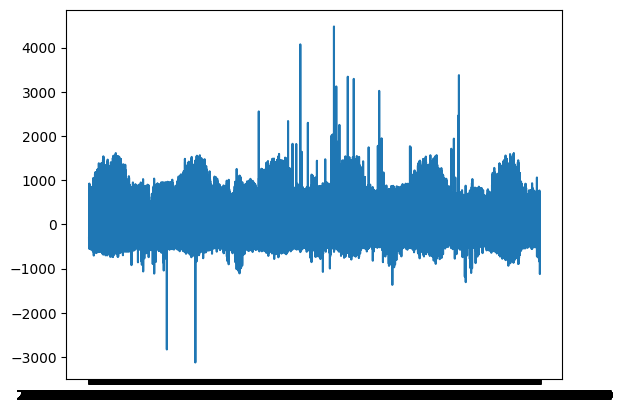

In [79]:
# ARIMA on first difference is suitable as the first difference is stationary
df_train['D.TOTALDEMAND'] = df_train['TOTALDEMAND'].diff()
plt.plot(df_train.index._mpl_repr(), df_train['D.TOTALDEMAND'], '-')
plt.show()

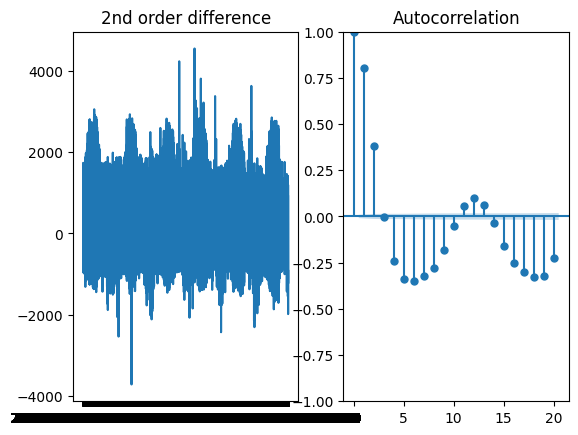

In [80]:
from statsmodels.graphics.tsaplots import plot_acf
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd order difference')
ax1.plot(df_train.TOTALDEMAND.diff(periods=2))

ax2 = f.add_subplot(122)
plot_acf(df_train.TOTALDEMAND.diff(periods=2).dropna(), ax=ax2, lags=20)
plt.show()

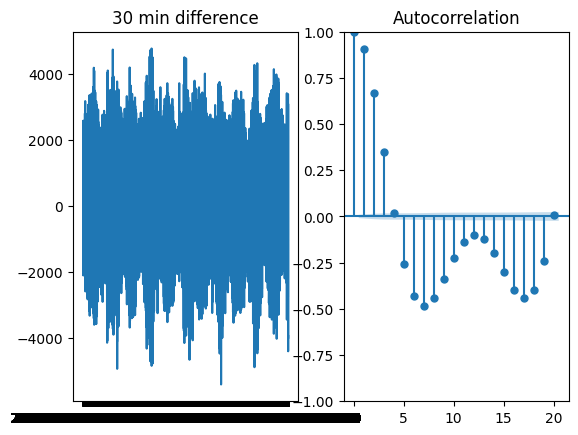

In [81]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('30 min difference')
ax1.plot(df_train.TOTALDEMAND.diff(periods=6))

ax2 = f.add_subplot(122)
plot_acf(df_train.TOTALDEMAND.diff(periods=6).dropna(), ax=ax2, lags=20)
plt.show()

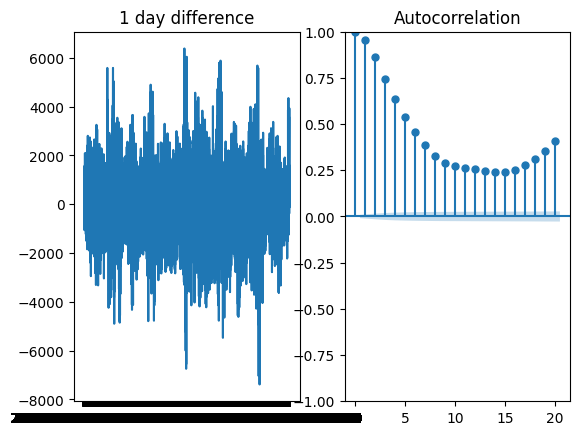

In [82]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1 day difference')
ax1.plot(df_train.TOTALDEMAND.diff(periods=(12*24)))

ax2 = f.add_subplot(122)
plot_acf(df_train.TOTALDEMAND.diff(periods=(12*24)).dropna(), ax=ax2, lags=20)
plt.show()

In [83]:
import numpy as np
import pandas as pd
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Define a function to fit SARIMA-X models and return AIC
def fit_arima_model(order):
    model = ARIMA(df_train[y], exog=df_train[X],
                    order=order)
    model_fit = model.fit()
    return model_fit

# Define ranges for p, d, q
p_values = range(0, 3)  # adjust as needed
d_values = range(0, 2)  # adjust as needed
q_values = range(0, 3)  # adjust as needed

best_aic = float("inf")
best_order = None
best_seasonal_order = None

# Iterate through different model configurations
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        print(f'trying: {p, d, q}')
        order = (p, d, q)
        aic = fit_arima_model(order).aic
        print(aic)
        
        if aic < best_aic:
            best_aic = aic
            best_order = order
    
    except Exception as e:
        continue

print(f"Best SARIMA-X Model (p, d, q): {best_order}")
print(f"Best AIC: {best_aic}")

# Fit the best model on the training data
best_model = ARIMA(df_train[y], exog=df_train[X],
                     order=best_order)
best_model_fit = best_model.fit()

# Forecast using the best model
forecast = best_model_fit.get_forecast(steps=len(df_test), exog=df_test[X])
forecast_mean = forecast.predicted_mean

# Evaluate the best model's performance
rmse = sqrt(mean_squared_error(df_test[y], forecast_mean))
print(f"Root Mean Squared Error (RMSE) of the Best Model: {rmse}")
from sklearn.metrics import r2_score

# Calculate the R-squared score
r_squared = r2_score(df_test[y], forecast_mean)
print(f"R-squared (R²) Score of the Best Model: {r_squared}")

trying: (0, 0, 0)
1268527.0058339497
trying: (0, 0, 1)
803039.5472828462
trying: (0, 0, 2)
788106.6116109586
trying: (0, 1, 0)
1181998.6811989166
trying: (0, 1, 1)
719124.8167111502
trying: (0, 1, 2)
677642.1812286412
trying: (1, 0, 0)
738357.0264585809
trying: (1, 0, 1)
735666.4488611103
trying: (1, 0, 2)
734888.4464013389
trying: (1, 1, 0)
682256.1075863005
trying: (1, 1, 1)
676642.8376581175
trying: (1, 1, 2)
675756.7749126294
trying: (2, 0, 0)
735121.6208543673
trying: (2, 0, 1)
735122.6972032557
trying: (2, 0, 2)
735418.3156519451
trying: (2, 1, 0)
673442.9023573983
trying: (2, 1, 1)
672089.6288066963
trying: (2, 1, 2)
671888.5222948587
Best SARIMA-X Model (p, d, q): (2, 1, 2)
Best AIC: 671888.5222948587
Root Mean Squared Error (RMSE) of the Best Model: 3789.875691823157
R-squared (R²) Score of the Best Model: -8.118281217824054


In [95]:
z_fit = fit_arima_model((2,0,2))
#z_fit = z.fit()
forecast = z_fit.get_forecast(steps=len(df_test), exog=df_test[X])
forecast_mean = forecast.predicted_mean

# Evaluate the best model's performance
mse = mean_squared_error(df_test[y], forecast_mean)
print(f"Mean Squared Error (MSE) of the Best Model: {mse}")

# Evaluate the best model's performance
rmse = sqrt(mean_squared_error(df_test[y], forecast_mean))
print(f"Root Mean Squared Error (MSE) of the Best Model: {rmse}")

from sklearn.metrics import r2_score

# Calculate the R-squared score
r_squared = r2_score(df_test[y], forecast_mean)
print(f"R-squared (R²) Score of the Best Model: {r_squared}")

Mean Squared Error (MSE) of the Best Model: 282803.1010914995
Root Mean Squared Error (MSE) of the Best Model: 531.7923477180726
R-squared (R²) Score of the Best Model: 0.8204657883587988


In [96]:
z_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            TOTALDEMAND   No. Observations:                47937
Model:                 ARIMA(2, 0, 2)   Log Likelihood             -328312.021
Date:                Mon, 02 Oct 2023   AIC                         656684.043
Time:                        18:21:10   BIC                         656947.372
Sample:                             0   HQIC                        656766.691
                              - 47937                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1536.6049   1.75e-11  -8.79e+13      0.000   -1536.605   -1536.605
Demand_Previous         0.7571   1.18e-06   6.42e+05      0.000       0.757       0.757
Demand_Lagged           0.0894   1.58e-06   5.64e+04      0.000       0.089       0.089
Demand_Rolling          0.1815   7.28e-07   2.49e+05      0.000       0.181       0.181
TEMPERATURE_lagged      4.1254   1.24e-08   3.34e+08      0.000       4.125       4.125
CPI_lagged              6.4075   1.48e-09   4.34e+09      0.000       6.407       6.407
Exports_lagged       -5.16e-10   2.18e-09     -0.237      0.813   -4.78e-09    3.75e-09
GDP_lagged            9.18e-10   4.78e-10      1.920      0.055    -1.9e-11    1.86e-09
Interest_lagged         5.7364   3.53e-11   1.62e+11      0.000       5.736       5.736
Residential_lagged  -1.686e-05   9.53e-05     -0.177      0.860      -0.000       0.000
Commercial_lagged    1.726e-05   3.92e-05      0.440      0.660   -5.96e-05    9.41e-05
SolarOutput_lagged     -0.0003      0.000     -1.789      0.074      -0.001    2.55e-05
Unemployment_lagged    17.0970   6.68e-10   2.56e+10      0.000      17.097      17.097
Price_lagged            0.0278   1.08e-07   2.56e+05      0.000       0.028       0.028
CommPrice_lagged       -1.2557   3.55e-09  -3.54e+08      0.000      -1.256      -1.256
HourOfDay              29.6443   2.24e-09   1.32e+10      0.000      29.644      29.644
DayOfYear               0.1181   5.88e-08   2.01e+06      0.000       0.118       0.118
IsWeekend             5.98e-14         -0       -inf      0.000    5.98e-14    5.98e-14
is_Sunday            -841.6993   1.04e-10  -8.13e+12      0.000    -841.699    -841.699
is_Monday            -298.8216   8.16e-11  -3.66e+12      0.000    -298.822    -298.822
is_Tuesday           -149.3160   3.45e-11  -4.33e+12      0.000    -149.316    -149.316
is_Wednesday         -204.6345   1.68e-10  -1.22e+12      0.000    -204.635    -204.635
is_Thursday          -147.7534   2.74e-11  -5.39e+12      0.000    -147.753    -147.753
is_Friday             243.3361   1.93e-10   1.26e+12      0.000     243.336     243.336
is_Saturday          -137.7162   2.92e-10  -4.72e+11      0.000    -137.716    -137.716
ar.L1                   1.2362   1.49e-06    8.3e+05      0.000       1.236       1.236
ar.L2                  -0.3759   1.22e-06  -3.07e+05      0.000      -0.376      -0.376
ma.L1                  -0.0527   4.17e-07  -1.26e+05      0.000      -0.053      -0.053
ma.L2                   0.0592   1.36e-07   4.36e+05      0.000       0.059       0.059
sigma2               5.204e+04      3e-12   1.73e+16      0.000     5.2e+04     5.2e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            415725.75
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             1.71
P

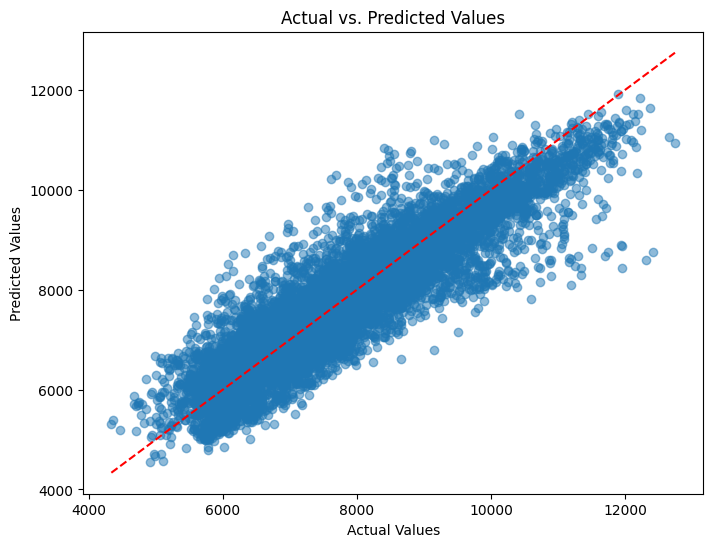

In [97]:
import matplotlib.pyplot as plt
#Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_test[y], forecast_mean, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(df_test[y]), max(df_test[y])], [min(df_test[y]), max(df_test[y])], color='red', linestyle='--')

plt.show()

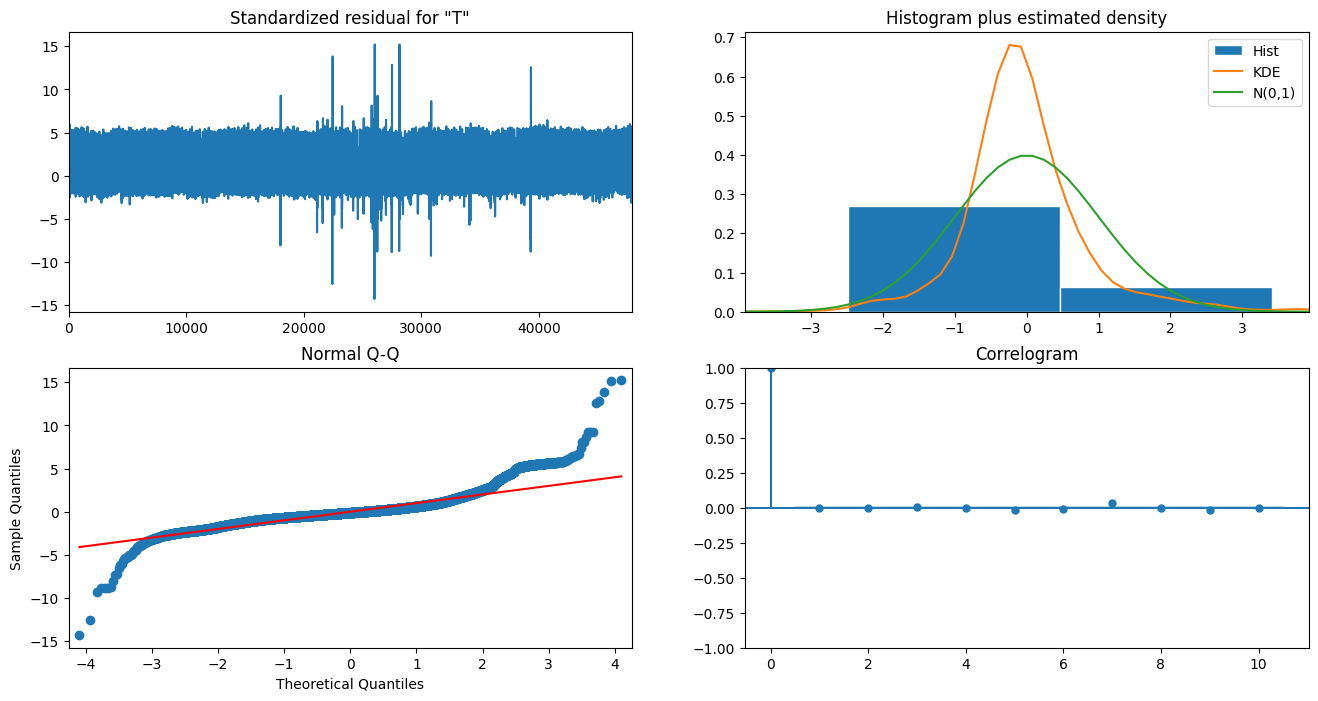

In [98]:
z_fit.plot_diagnostics(figsize=(16, 8))
plt.show()